In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from math import sqrt

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def vape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))/np.mean(np.abs(y_true))
import gc

gc.enable()

# Importing LGBM and XGBOOST
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation

import plotly.express as px
from IPython.display import display, HTML

import shap

shap.initjs()

import mlflow
import mlflow.lightgbm

In [2]:
cwd = os.getcwd()
data_store_path_dir = os.path.join(cwd, "../data_tmp/")

In [3]:
df_original = pd.read_parquet(os.path.join(data_store_path_dir, "train.parquet"))

In [4]:
df = df_original.drop(["campaign_name",
         "campaign_status",
         "keyword",
         "keyword_match_type",
         "ad_group","client_profile_id","date_obj"], axis=1, errors='ignore').copy()


In [5]:
df.head()

,date,cpc,clicks,campaign_name_0_category,campaign_name_1_category,campaign_name_2_category,campaign_name_3_category,campaign_name_4_category,campaign_name_5_category,campaign_name_6_category,...,ad_group_2_category,ad_group_3_category,ad_group_4_category,keyword_match_type_0_category,month_dt,day_in_month_dt,day_of_week_dt,day_in_year_dt,week_in_year_dt,is_holiday
0,2021-07-03,0.000,0,314,37,34,319,276,170,182,...,301,329,329,139,7,3,5,184,26,False
1,2021-07-01,19.055,2,268,34,246,276,170,14,329,...,329,329,329,323,7,1,3,182,26,True
2,2020-05-13,0.000,0,314,7,329,329,329,329,329,...,329,329,329,245,5,13,2,134,20,False
3,2020-02-06,0.000,0,314,122,321,12,329,329,329,...,329,329,329,245,2,6,3,37,6,False
4,2020-04-18,0.000,0,268,34,319,276,170,182,329,...,312,329,329,139,4,18,5,109,16,False


In [6]:
df.columns

Index(['date', 'cpc', 'clicks', 'campaign_name_0_category',
       'campaign_name_1_category', 'campaign_name_2_category',
       'campaign_name_3_category', 'campaign_name_4_category',
       'campaign_name_5_category', 'campaign_name_6_category',
       'campaign_name_7_category', 'campaign_name_8_category',
       'campaign_name_9_category', 'campaign_name_10_category',
       'keyword_0_category', 'keyword_1_category', 'keyword_2_category',
       'keyword_3_category', 'keyword_4_category', 'keyword_5_category',
       'ad_group_0_category', 'ad_group_1_category', 'ad_group_2_category',
       'ad_group_3_category', 'ad_group_4_category',
       'keyword_match_type_0_category', 'month_dt', 'day_in_month_dt',
       'day_of_week_dt', 'day_in_year_dt', 'week_in_year_dt', 'is_holiday'],
      dtype='object')

In [7]:
train_columns = ["date",'month_dt', 'day_in_month_dt',
       'day_of_week_dt', 'week_in_year_dt', 'is_holiday',"day_in_year_dt"]

In [8]:
df_by_day = df.groupby(train_columns, as_index=False).agg({
    "clicks":sum
})

In [9]:
df_by_day.head()

,date,month_dt,day_in_month_dt,day_of_week_dt,week_in_year_dt,is_holiday,day_in_year_dt,clicks
0,2018-01-01,1,1,0,1,True,1,112
1,2018-01-02,1,2,1,1,False,2,216
2,2018-01-03,1,3,2,1,False,3,167
3,2018-01-04,1,4,3,1,False,4,175
4,2018-01-05,1,5,4,1,False,5,158


In [10]:
df_by_day.loc[df_by_day['clicks'] > 400 , 'clicks'] = 400
df_by_day['bidder_impact'] = False

df_by_day.loc[df_by_day['date'] > "2020-10-01" , 'bidder_impact'] = True

df_by_day['new_befaviour'] = False

df_by_day.loc[df_by_day['date'] > "2022-06-01" , 'new_befaviour'] = True

In [11]:
for c in df_by_day.columns:
    col_type = df_by_day[c].dtype
    if c == "date":
        continue
    if col_type == 'object' or col_type.name == 'category' or "category" in c:
        df_by_day[c] = df_by_day[c].astype('category')

In [12]:
val_df = df_by_day[df_by_day["date"] > "2023-01-01"]
val_df.shape

(33, 10)

In [13]:
df_by_day =df_by_day [df["date"] <= "2023-01-01"]
df_by_day.shape

Boolean Series key will be reindexed to match DataFrame index.


(1847, 10)

In [14]:
y = df_by_day['clicks']
X = df_by_day.drop(['clicks',"date"], axis=1)
val_x =val_df.drop(['clicks',"date"], axis=1)
val_y = val_df['clicks']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314)

In [16]:
mlflow.lightgbm.autolog()

2023/02/11 23:47:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of lightgbm. If you encounter errors during autologging, try upgrading / downgrading lightgbm to a supported version, or try upgrading MLflow.


In [40]:
mlflow.start_run(run_name="click_for_day")

train_parameters = {
  "boosting_type": "gbdt",
  "num_leaves": 5,
  "max_depth": 100,
  "learning_rate": 0.001,
  "n_estimators": 10000,
  "subsample_for_bin": 40000,
  "objective": "regression",
  "min_split_gain": 0.36004551515184435,
  "min_child_weight": 6.680517668416932,
  "min_child_samples": 12,
  "subsample": 0.8113890445491936,
  "subsample_freq": 99,
  "colsample_bytree": 0.5100181540136696,
  "reg_alpha": 27.569704821799697,
  "reg_lambda": 95.00039766093927,
  "n_jobs": -1,

  "importance_type": "split",
    #Shows debug and warning level information (silent - is depricated) , verbose as parameter
      #"silent": True,
    # -1 value means - off some output
    "verbose":0,
    "force_col_wise" : True
}
fit_params={
            "eval_metric" : ['l1','l2'],
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['error'],
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }
num_round =50

In [41]:
lgg = lgb.LGBMRegressor(**train_parameters)

In [42]:
model = lgg.fit(X_train, 
                y_train, 
                callbacks=[early_stopping(100),log_evaluation(10)],
                **fit_params)

Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	error's l1: 78.9142	error's l2: 9045.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	error's l1: 78.7557	error's l2: 9009.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	error's l1: 78.6026	error's l2: 8975.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	error's l1: 78.436	error's l2: 8938.76
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	error's l1: 78.2791	error's l2: 8904.59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	error's l1: 78.1286	error's l2: 88

2023/02/11 23:53:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vyacheslav/.pyenv/versions/3.9.12/envs/adhome_ml/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


<AxesSubplot: >

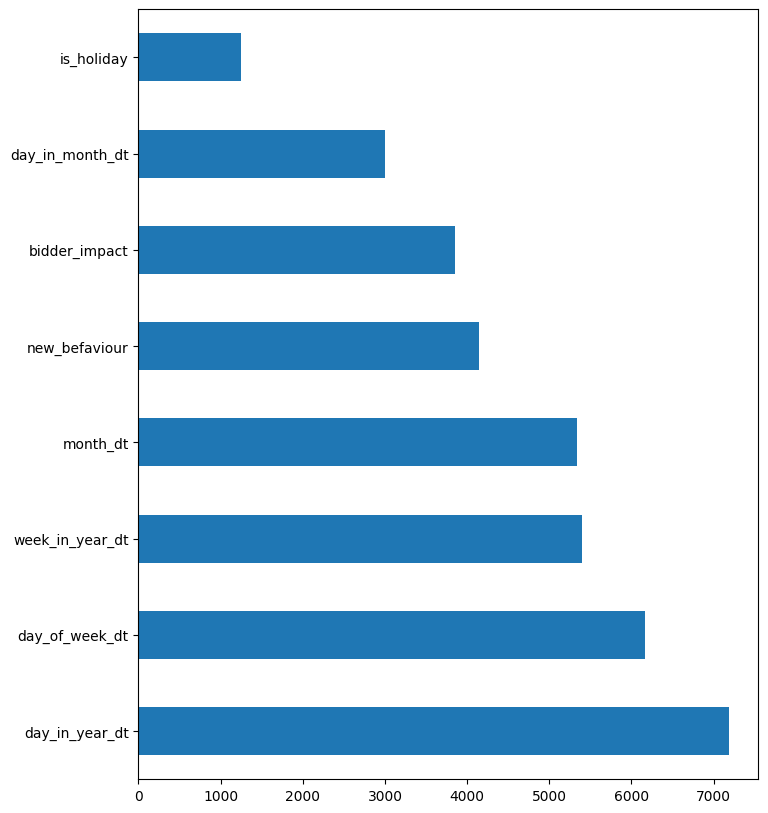

In [43]:
feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

In [44]:

def show_staistics(model, X_dataset , y_data_set):
    y_pred = model.predict(X_dataset)
    mse = mean_squared_error(y_data_set, y_pred)
    
    print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
    print("The mean absolute error (MAE) on test set: {:.4f}".format(mean_absolute_error(y_data_set, y_pred)))
    print("The RMSE on test set: {:.4f}".format(sqrt(mse)))
    print("The r2_score on test set: {:.4f}".format(r2_score(y_data_set, y_pred)))
    print("The smape on test set: {:.4f}".format(smape(y_data_set, y_pred)))
    print("The vape on test set: {:.4f}".format(vape(y_data_set, y_pred)))
    mlflow.log_metrics({
        "MSE": mse,
        "MAE": mean_absolute_error(y_data_set, y_pred),
        "RMSE":sqrt(mse),
        "r2_score":r2_score(y_data_set, y_pred)
    })

In [45]:
show_staistics(model, X_test , y_test)
mlflow.end_run()

The mean squared error (MSE) on test set: 4828.2816
The mean absolute error (MAE) on test set: 54.5178
The RMSE on test set: 69.4858
The r2_score on test set: 0.4613
The smape on test set: 28.9017
The vape on test set: 0.2657


In [156]:
df_by_day['pred'] = model.predict(df_by_day.drop(['clicks',"pred","date_obj","date"], axis=1, errors="ignore"))
df_by_day['date_obj'] = pd.to_datetime(df_by_day['date']).dt.date
df_gp = df_by_day.groupby(['date_obj'], as_index=False).agg({
    "clicks": sum,
    "pred":sum
})

In [157]:

fig = px.line(df_gp, x="date_obj", y=["clicks","pred"], title='Validation Real CPC')
fig.show()

In [159]:
df_by_day.to_csv(os.path.join(data_store_path_dir, "click_for_day.csv"))